In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter

In [2]:
def read_data(name_sub_folder):
  # function to read data from subfolder and concat them into one dataframe
  # according to the structure of the Pfam dataset from Kaggle:
  # https://www.kaggle.com/datasets/googleai/pfam-seed-random-split/data
  full_data = []
  for f in os.listdir(os.path.join('random_split/random_split', name_sub_folder)):
    data = pd.read_csv(os.path.join('random_split/random_split', name_sub_folder, f))
    full_data.append(data)
  return pd.concat(full_data)  

df_train = read_data('train')
df_test = read_data('test')

In [3]:
# Find the counts of all the classes in the training set:
counts_dict_train = df_train['family_accession'].value_counts().to_dict()

# make a dataframe with the counts of all the classes in the training set:
counts_df_train = pd.DataFrame.from_dict(counts_dict_train, orient='index')
counts_df_train.columns = ['count']
counts_df_train.index.name = 'class'

# test set:
counts_dict_test = df_test['family_accession'].value_counts().to_dict()
counts_df_test = pd.DataFrame.from_dict(counts_dict_test, orient='index')
counts_df_test.columns = ['count']
counts_df_test.index.name = 'class'



### Distribution of the number of samples per class

The plot below shows that the number of samples per class is highly unbalanced, with the majority of classes having very few samples. This is a problem for training a neural network, as the network will be biased towards the majority classes. To address this, we will omit the classes with fewer than 200 samples from the training set in the main project. 

Ideally, there would be a way to artificially generate more samples for the minority classes by using a weighted sampling scheme during training. Alternatively, an augmentation scheme would typically be an option for many types of data, however for biological data this is not a trivial step. DNA sequences can for example be augmented through k-mer permutation and wrapping, however protein sequences have an ab-initio sequence-to-strucutre relationship that is not easily augmented.


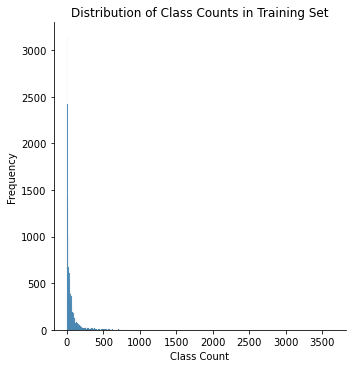

In [4]:
# make a distribution plot of the class counts:
sns.displot(counts_df_train['count'], kde=False)
plt.title('Distribution of Class Counts in Training Set')
# plt.xlim(0,500)
plt.xlabel('Class Count')
plt.ylabel('Frequency')
plt.show()


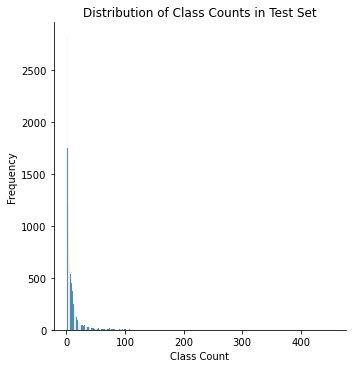

In [5]:
# make a distribution plot of the class counts:
sns.displot(counts_df_test['count'], kde=False)
plt.title('Distribution of Class Counts in Test Set')
# plt.xlim(0,500)
plt.xlabel('Class Count')
plt.ylabel('Frequency')
plt.show()


In [6]:
# remove the classes with fewer than MIN_CLASS_SIZE counts:

MIN_CLASS_SIZE = 200

classes_to_remove = counts_df_train[counts_df_train['count'] < MIN_CLASS_SIZE].index.tolist()
df_train = df_train[~df_train['family_accession'].isin(classes_to_remove)]

# Find the counts of all the classes in the training set:
counts_dict_train = df_train['family_accession'].value_counts().to_dict()

# make a dataframe with the counts of all the classes in the training set:
counts_df_train = pd.DataFrame.from_dict(counts_dict_train, orient='index')
counts_df_train.columns = ['count']
counts_df_train.index.name = 'class'

# now for test, remove same classes:
df_test = df_test[~df_test['family_accession'].isin(classes_to_remove)]

# Find the counts of all the classes in the training set:
counts_dict_test = df_test['family_accession'].value_counts().to_dict()
counts_df_test = pd.DataFrame.from_dict(counts_dict_test, orient='index')
counts_df_test.columns = ['count']
counts_df_test.index.name = 'class'

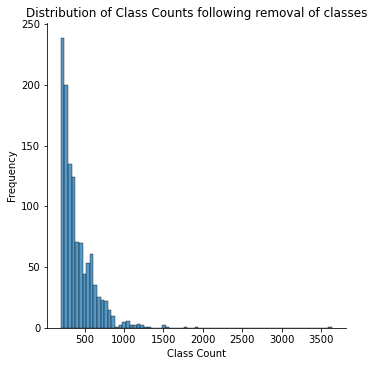

In [7]:
# make a distribution plot of the class counts:
sns.displot(counts_df_train['count'], kde=False)
plt.title('Distribution of Class Counts following removal of classes')
plt.xlabel('Class Count')
plt.ylabel('Frequency')
plt.show()


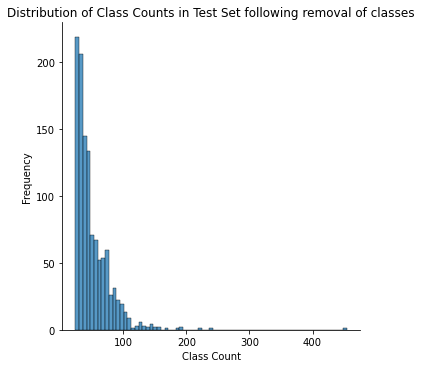

In [8]:
# test set:
sns.displot(counts_df_test['count'], kde=False)
plt.title('Distribution of Class Counts in Test Set following removal of classes')
plt.xlabel('Class Count')
plt.ylabel('Frequency')
plt.show()


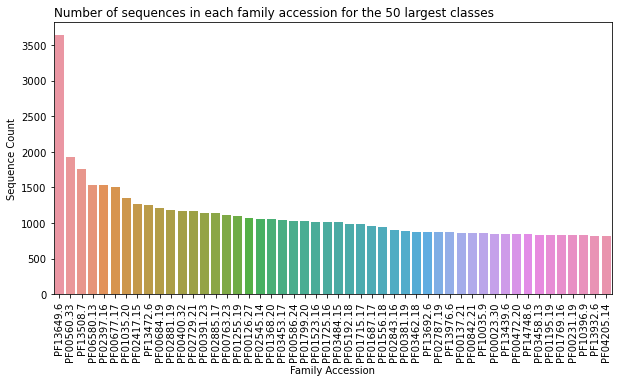

In [9]:
# for the largest 50 classes, plot a barchart of the number of sequences in each family accession:
counts_df_train = counts_df_train.sort_values(by='count', ascending=False)
counts_df_train_50 = counts_df_train.iloc[:50, :]
plt.figure(figsize=(10,5))
sns.barplot(x=counts_df_train_50.index, y=counts_df_train_50['count'])
plt.title('Number of sequences in each family accession for the 50 largest classes', loc='left')
plt.xlabel('Family Accession')
plt.ylabel('Sequence Count')
plt.xticks(rotation=90)
plt.show()

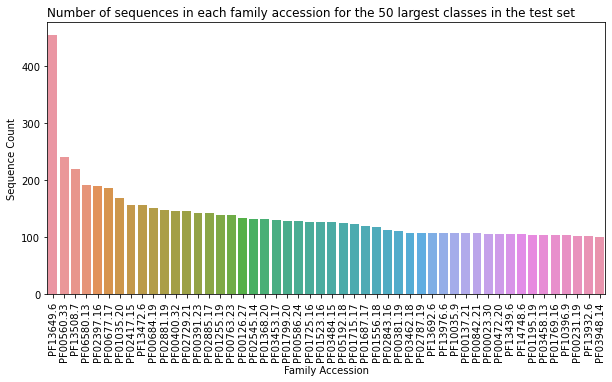

In [10]:
# test set:
counts_df_test = counts_df_test.sort_values(by='count', ascending=False)
counts_df_test_50 = counts_df_test.iloc[:50, :]
plt.figure(figsize=(10,5))
sns.barplot(x=counts_df_test_50.index, y=counts_df_test_50['count'])
plt.title('Number of sequences in each family accession for the 50 largest classes in the test set', loc='left')
plt.xlabel('Family Accession')
plt.ylabel('Sequence Count')
plt.xticks(rotation=90)
plt.show()


### Sequence length distribution

The plot below shows that the sequence lengths are highly variable, fortunately for a Transformer model, the sequence length is not a limiting factor as the tokenization scheme enables them to handle sequences of varying lengths, making them robust to different input sizes. This cannot be said for other models such an RNNs or CNNs, which require a fixed input size. In those cases, the sequences would have to be truncated or padded to a fixed length, which would result in a loss of information.

There is however a cap on the size of each sequence imposed by the ESM2 model, which is 1024 tokens. This is not a problem for the majority of the sequences, however there are a few outliers that are longer than 1024 tokens. These will have to be truncated to 1024 tokens, which will result in a loss of information.

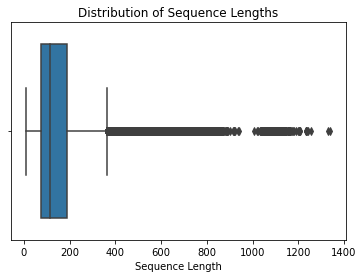

In [11]:
# count the length of the sequence for each sample:
df_train['len_sequence'] = df_train['sequence'].apply(len)
df_train['len_aligned_sequence'] = df_train['aligned_sequence'].apply(len)
# plot the distribution of sequence lengths:
sns.boxplot(x='len_sequence', data=df_train, showfliers=True)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.show()

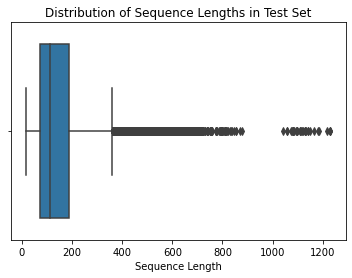

In [12]:
# test set:
df_test['len_sequence'] = df_test['sequence'].apply(len)
df_test['len_aligned_sequence'] = df_test['aligned_sequence'].apply(len)
# plot the distribution of sequence lengths:
sns.boxplot(x='len_sequence', data=df_test, showfliers=True)
plt.title('Distribution of Sequence Lengths in Test Set')
plt.xlabel('Sequence Length')
plt.show()

### Amino acid frequency

The frequency of amino acids is related to the functional and structural properties of the protein sequences in the Pfam dataset. Some amino acids are more prevalent in specific regions of proteins, such as catalytic sites, binding domains, or transmembrane regions and can be an indirect probe to the diversity of the protein sequences in our training set. 

The plot shows that the amino acid frequencies are of a high order of magnitude, which is expected for a dataset of this size. Both train and test sets have a similar distribution. This distribution resembles the distribution of amino acids for the UniProt dataset:

![UniProtDist](https://www.ebi.ac.uk/inc/drupal/uniprot/statistics/relstat2.gif )


Some rare amino acids are not present, which is expected. These include O (pyrrolysine), U (selenocysteine), whereas B is a combined label for N or D and X is an unknown.

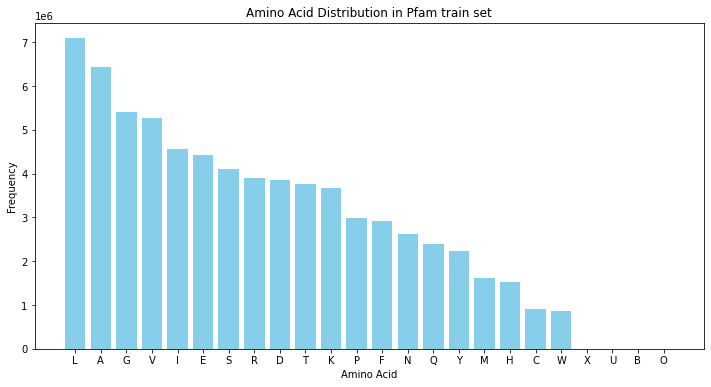

In [13]:
sequences = df_train['sequence']

# Concatenate all sequences into a single string
all_sequences = ''.join(sequences)
# Use Counter to count the frequency of each amino acid
amino_acid_counts = Counter(all_sequences)
# Convert the Counter object to a DataFrame
amino_acid_df = pd.DataFrame(list(amino_acid_counts.items()), columns=['Amino Acid', 'Frequency'])
# Sort the DataFrame by frequency in descending order
amino_acid_df = amino_acid_df.sort_values(by='Frequency', ascending=False)

# Plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(amino_acid_df['Amino Acid'], amino_acid_df['Frequency'], color='skyblue')
plt.xlabel('Amino Acid')
plt.ylabel('Frequency')
plt.title('Amino Acid Distribution in Pfam train set')
plt.show()

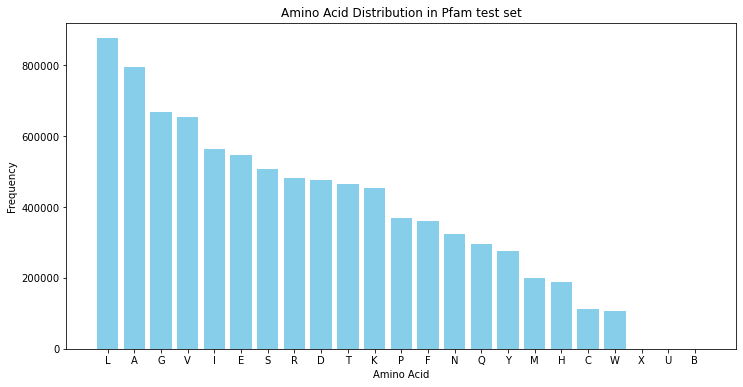

In [14]:
# test set:
sequences = df_test['sequence']

# Concatenate all sequences into a single string
all_sequences = ''.join(sequences)
# Use Counter to count the frequency of each amino acid
amino_acid_counts = Counter(all_sequences)
# Convert the Counter object to a DataFrame
amino_acid_df = pd.DataFrame(list(amino_acid_counts.items()), columns=['Amino Acid', 'Frequency'])
# Sort the DataFrame by frequency in descending order
amino_acid_df = amino_acid_df.sort_values(by='Frequency', ascending=False)

# Plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(amino_acid_df['Amino Acid'], amino_acid_df['Frequency'], color='skyblue')
plt.xlabel('Amino Acid')
plt.ylabel('Frequency')
plt.title('Amino Acid Distribution in Pfam test set')
plt.show()